In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/simulation_prox/simulation_figures/"
os.chdir(myDir)
import ProxseqClasses as PC

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
#*****
# Seed number
np.random.seed(2019)
random.seed(2019)

#%% Simulation parameters
# Define the circle diameter in nm, centered at 0
d = 10000

# PLA ligation distance in nm (two antibodies within this distance can be ligated)
PLA_dist = 50

# Binomial distribution
p = (PLA_dist/d)**2

In [ ]:
#%% Check the simulation of probes
np.random.seed(1)
test = PC.randomPointGen3D(500)
fig, ax = plt.subplots(ncols=2, figsize=(6,3))
ax[0].scatter(test[:,0], test[:,1], s=10)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[1].scatter(test[:,0], test[:,2], s=10)
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
fig.tight_layout()

In [ ]:
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test[:,0], test[:,1], test[:,2], s=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [15]:
#%% Import real data
dge_real = pd.read_csv("/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/simulation_reproduce figures/tutorial_count_matrix.txt.gz", index_col=0, delimiter="\t")

# Filter cells
# Keep cells with > 10 UMIs and below 30k UMIs
dge_real = dge_real.loc[:,(dge_real.sum(axis=0)>10) & (dge_real.sum(axis=0)<30000)]
# Keep cells with more than 20 detected PLA products
dge_real = dge_real.loc[:,((dge_real>0).sum(axis=0)>20)]

# Cell-type data
dge_real_T = dge_real.loc[:,dge_real.columns.str.contains("Jurkat")]
dge_real_B = dge_real.loc[:,dge_real.columns.str.contains("Raji")]
pla_T = PC.plaObject(dge_real_T, non_proximal_marker="free_oligo")
pla_B = PC.plaObject(dge_real_B, non_proximal_marker="free_oligo")

# Protein count
pla_T.calculateProteinCount()
pla_B.calculateProteinCount()

# Probe count from PLA products
pla_T.calculateProbeCount()
pla_B.calculateProbeCount()

# Protein complex prediction
pla_T.predictComplex()
pla_T.predictComplex(method='lr', suffix='2')
lr_T = pla_T.lr_params2
pla_B.predictComplex()
pla_B.predictComplex(method='lr', suffix='2')
lr_B = pla_B.lr_params2

predictComplex done: Loop number 200, tolerance 2.75
predictComplex done: Loop number 200, tolerance 7.99


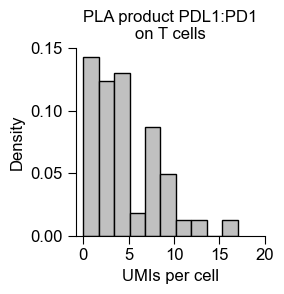

In [42]:
#Fig 1d
fig, ax = plt.subplots(figsize=(3,3.1))
ax.hist(pla_T.pla_count.loc["PDL1:PD1",:], density=True, color='silver', ec='k')
ax.set_xticks(range(0,21,5))
# ax.set_xlim(0,20)
ax.set_yticks(np.arange(0,0.16,0.05))
ax.set_xlabel("UMIs per cell")
ax.set_ylabel("Density")
ax.set_title("PLA product PDL1:PD1\non T cells")
sns.despine(fig=fig)
fig.tight_layout()
fig.savefig(myDir+"Tcells_PDL1PD1_count_Fig 1d.svg", bbox_inches='tight', pad_inches=0)

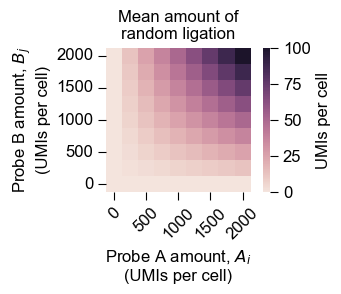

In [41]:
#Fig 1e
# Binomial approximation
A = np.arange(0,2001,250)
B = np.arange(0,2001,250)
x, y = np.meshgrid(A, B, indexing='xy')
z = pd.DataFrame(p*x*y, index=B, columns=A)
# Flip data frame
z = z.iloc[::-1,:]

# Plot heatmap of binomial distribution approximation   **Figure 1e**
fig, ax = plt.subplots(figsize=(4,3.1))
sns.heatmap(data=z, ax=ax, square=True, cbar_kws={'label':'UMIs per cell'},
            xticklabels=2, yticklabels=2,
            cmap=sns.cubehelix_palette(light=.91, dark=0.1, as_cmap=True))
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(labels=ax.get_yticklabels(), rotation=0)
ax.set_xlabel(r"Probe A amount, $A_i$"+"\n(UMIs per cell)")
ax.set_ylabel(r"Probe B amount, $B_j$"+"\n(UMIs per cell)")
ax.set_title("Mean amount of\nrandom ligation")
fig.tight_layout()
fig.savefig(myDir+"binomial_heatmap_Fig 1e.svg", bbox_inches='tight', pad_inches=0)

In [43]:
# Simulate 5 targets **Fig 2b simulation**
num_complex = np.zeros((5,5))
num_complex[0,0] = 100
# num_complex[1,1] = 40
num_complex[1,0] = 50
num_complex[0,1] = 50
probeA = np.array([2000,1000,500,200,100])
probeB = np.array([2000,1000,500,200,100])

# No variance
sim0 = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                      seed_num=2019, protein_variance=False, ligate_all=False)
sim0.simulate(num_complex, probeA, probeB)
dge0 = PC.plaObject(sim0.pla_count)
dge0.calculateProteinCount()

# Protein variance only
sim1 = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                      seed_num=2019, protein_variance=True,  ligate_all=False)
sim1.simulate(num_complex, probeA, probeB)
dge1 = PC.plaObject(sim1.pla_count)
dge1.calculateProteinCount()

cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:23:44     Start simulation
2023-01-26 14:23:45     Processed     10 cells
2023-01-26 14:23:45     Processed     20 cells
2023-01-26 14:23:46     Processed     30 cells
2023-01-26 14:23:47     Processed     40 cells
2023-01-26 14:23:47     Processed     50 cells
2023-01-26 14:23:48     Processed     60 cells
2023-01-26 14:23:49     Processed     70 cells
2023-01-26 14:23:49     Processed     80 cells
2023-01-26 14:23:50     Processed     90 cells
2023-01-26 14:23:50     Processed    100 cells
cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2019.
2023-01-26 14:23:50     Start simulation
2023-01-26 14:23:53     Processed     10 cells
2023-01-26 14:23:54     Processed     20 cells
2023-01-26 14:23:55     Processed     30 cells
2023-01-26 14:23:57     Processed     40 cells
2023-01-26 14:23:58     Processed     50 cells
2023-01-26 14:23:59     Processed     60 cells
2023-01-26 14:24:00     

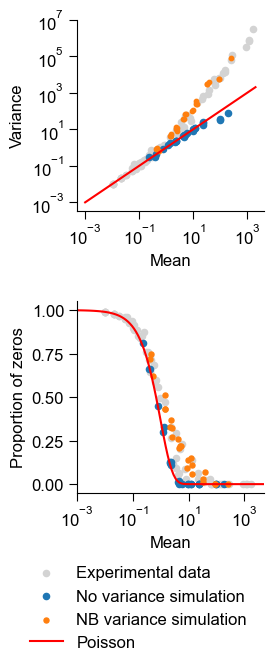

In [46]:
#Fig 2b
fig, ax = plt.subplots(nrows=2, figsize=(2.9,7))
ax[0].scatter(pla_T.pla_count.mean(axis=1), pla_T.pla_count.var(axis=1),
              color='lightgrey', s=20, label="Experimental data")
# ax[0].scatter(pla_B.pla_count.mean(axis=1), pla_B.pla_count.var(axis=1),
#               color='lightgrey', s=20, label="Real data")
ax[0].plot([1e-3,2e3],[1e-3,2e3], color='red', label="Poisson")
ax[0].scatter(sim0.pla_count.mean(axis=1), sim0.pla_count.var(axis=1), s=20, label="No variance\nsimulation")
ax[0].scatter(sim1.pla_count.mean(axis=1), sim1.pla_count.var(axis=1), s=10, label="NB variance\nsimulation")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xticks([1e-3,1e-1,1e1,1e3])
ax[0].set_yticks([1e-3,1e-1,1e1,1e3,1e5,1e7])
ax[0].set_xlabel("Mean")
ax[0].set_ylabel("Variance")

x = np.logspace(-3, 4, num=100)
ax[1].scatter(pla_T.pla_count.mean(axis=1), (pla_T.pla_count==0).sum(axis=1)/pla_T.pla_count.shape[1],
              color='lightgrey', s=20, label="Experimental data")
# ax[1].scatter(pla_B.pla_count.mean(axis=1), (pla_B.pla_count==0).sum(axis=1)/pla_B.pla_count.shape[1],
#               color='lightgrey', s=20)
ax[1].scatter(sim0.pla_count.mean(axis=1), (sim0.pla_count==0).sum(axis=1)/sim0.pla_count.shape[1],
              s=20, label="No variance simulation")
ax[1].scatter(sim1.pla_count.mean(axis=1), (sim1.pla_count==0).sum(axis=1)/sim1.pla_count.shape[1],
              s=13, label="NB variance simulation")
ax[1].plot(x, np.exp(-x), color='red', label="Poisson")
ax[1].set_xlabel("Mean")
ax[1].set_ylabel("Proportion of zeros")
ax[1].set_xscale('log')
ax[1].set_xlim(1e-3,5e3)
ax[1].set_xticks([1e-3,1e-1,1e1,1e3])
handles, labels = ax[1].get_legend_handles_labels()
handles.append(handles[0])
labels.append(labels[0])
ax[1].legend(handles=handles[1:], labels=labels[1:], loc='upper center',
             bbox_to_anchor=(0.33, -0.3), frameon=False) # fancybox=False, edgecolor='black'
sns.despine(fig=fig)
fig.tight_layout(h_pad=2)
fig.savefig(myDir+"real_simulation_poisson_Fig 2b.svg", bbox_inches='tight', pad_inches=0)

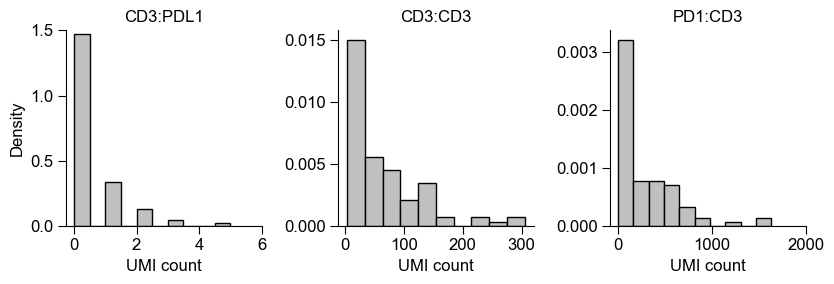

In [51]:
#Fig 2c
fig, ax = plt.subplots(ncols=3, figsize=(8.5,3), tight_layout=True)
ax[0].hist(pla_T.pla_count.loc["CD3:PDL1",:], color="silver", ec="black",
           bins=10, density=True)
ax[0].set_title("CD3:PDL1")
ax[0].set_ylabel("Density")
ax[0].set_xlabel("UMI count")
ax[0].set_ylim(0,1.5)
ax[0].set_xticks(range(0,7,2))
ax[0].set_yticks([0,0.5,1,1.5])
ax[1].hist(pla_T.pla_count.loc["CD3:CD3",:], color="silver", ec="black",
           bins=10, density=True)
ax[1].set_xticks(range(0,301,100))
# ax[1].set_ylim(0,0.015)
ax[1].set_title("CD3:CD3")
ax[1].set_xlabel("UMI count")
ax[2].hist(pla_T.pla_count.loc["PD1:CD3",:], color="silver", ec="black",
           bins=10, density=True)
ax[2].set_title("PD1:CD3")
ax[2].set_xlabel("UMI count")
ax[2].set_xticks(range(0,2001,1000))
# ax[2].set_ylim(0,0.003)
sns.despine(fig=fig)
fig.savefig(myDir+"realdata_hist_Fig 2c.svg", bbox_inches='tight', pad_inches=0)

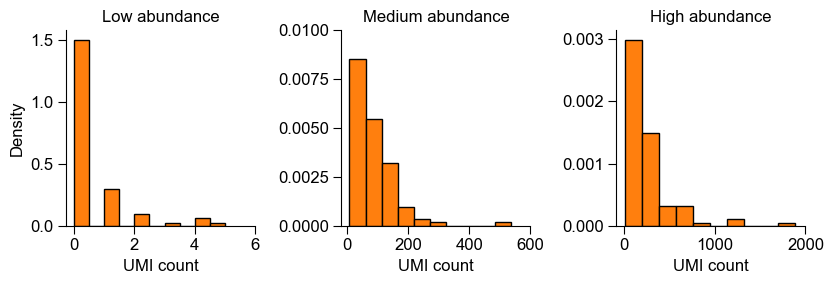

In [49]:
#Fig 2d
# Simulated data     *Figure 2d**
fig, ax = plt.subplots(ncols=3, figsize=(8.5,3), tight_layout=True)
ax[0].hist(sim1.pla_count.loc["5:5",:], color="silver", ec="black",
           fc="tab:orange", bins=10, density=True)
ax[0].set_title("Low abundance")
ax[0].set_xticks(range(0,7,2))
ax[0].set_ylabel("Density")
ax[0].set_xlabel("UMI count")
ax[1].hist(sim1.pla_count.loc["1:2",:], color="silver", ec="black",
           fc="tab:orange", bins=10, density=True)
ax[1].set_title("Medium abundance")
ax[1].set_xlabel("UMI count")
ax[1].set_yticks(np.arange(0,0.011,0.0025))
ax[1].set_xticks(range(0,601,200))
ax[2].hist(sim1.pla_count.loc["1:1",:], color="silver", ec="black",
           fc="tab:orange", bins=10, density=True)
ax[2].set_title("High abundance")
ax[2].set_xlabel("UMI count")
ax[2].set_xticks(range(0,2001,1000))
sns.despine(fig=fig)
fig.savefig(myDir+"simulation_hist_Fig 2d.svg", bbox_inches='tight', pad_inches=0)

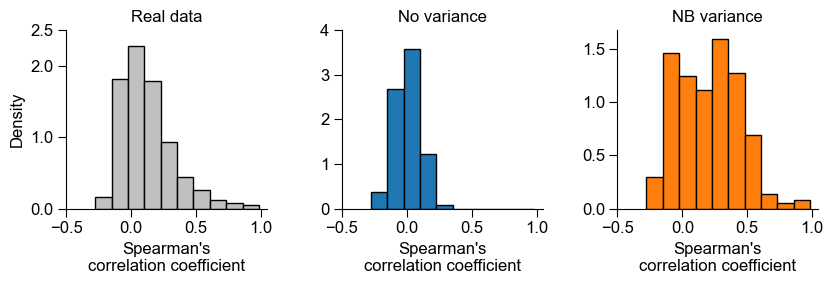

In [50]:
#Fig 2e
# Histogram of pairwise correlation coefficient   **Figure 2e**
# Real data
my_corr = pla_T.pla_count.T.corr(method="spearman").to_numpy()
# Extract non duplicate non-diagonal cofficients
my_corr = my_corr[np.triu_indices(my_corr.shape[0], k=1)]
# Plot non diagonal correlation coefficients
fig, ax = plt.subplots(ncols=3, figsize=(8.5,3))
my_breaks = ax[0].hist(my_corr[np.isfinite(my_corr)], color="silver", ec="black", bins=10,
                       density=True)
# ax[0].set_xlim(-0.5,1.1)
# ax[0].set_ylim(0, 3)
ax[0].set_yticks([0,1,2,2.5])
ax[0].set_title("Real data")
ax[0].set_xlabel("Spearman's\ncorrelation coefficient")
ax[0].set_ylabel("Density")

# Without variance model
my_corr = sim0.pla_count.T.corr(method="spearman").to_numpy()
# Extract non duplicate non-diagonal cofficients
my_corr = my_corr[np.triu_indices(my_corr.shape[0], k=1)]
# Plot non diagonal correlation coefficients
ax[1].hist(my_corr[np.isfinite(my_corr)], color="silver", ec="black",
           fc="tab:blue", bins=my_breaks[1], density=True)
# ax[1].set_xlim(-0.5,1.1)
ax[1].set_ylim(0,4)
ax[1].set_title("No variance")
ax[1].set_xlabel("Spearman's\ncorrelation coefficient")
# Protein variance only
my_corr = sim1.pla_count.T.corr(method="spearman").to_numpy()
# Extract non duplicate non-diagonal cofficients
my_corr = my_corr[np.triu_indices(my_corr.shape[0], k=1)]
# Plot non diagonal correlation coefficients
ax[2].hist(my_corr[np.isfinite(my_corr)], color="silver", ec="black",
           fc="tab:orange", bins=my_breaks[1], density=True)
# ax[2].set_xlim(-0.5,1.1)
ax[2].set_title("NB variance")
ax[2].set_xlabel("Spearman's\ncorrelation coefficient")
for i in ax:
    i.set_xticks([-0.5,0,0.5,1])
sns.despine(fig=fig)
fig.tight_layout(w_pad=2)
fig.savefig(myDir+"spearman_hist_Fig 2e.svg", bbox_inches='tight', pad_inches=0)

cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:37:44     Start simulation
cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:37:44     Start simulation
cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:37:45     Start simulation
cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:37:45     Start simulation
cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:37:46     Start simulation
cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:37:50     Start simulation
cell_d=10000. PLA_dist=10.
protein_variance=False.
2023-01-26 14:38:05     Start simulation
cell_d=10000. PLA_dist=50.
protein_variance=False.
2023-01-26 14:38:06     Start simulation
cell_d=10000. PLA_dist=100.
protein_variance=False.
2023-01-26 14:38:06     Start simulation
cell_d=10000. PLA_dist=150.
protein_variance=False.
2023-01-26 14:38:07     Start simulation
cell_d=10000. PLA_dist=200.
protein_variance=False.
2023-01-26 14:38:07     St

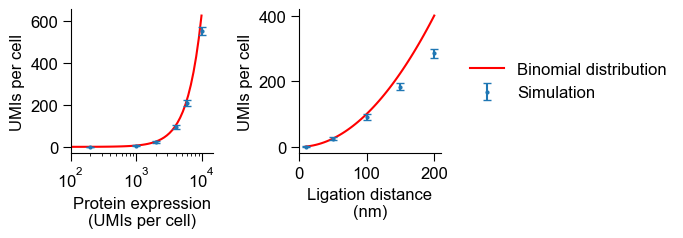

In [53]:
#Fig 3a
num_complex = np.zeros((1,1))
sim = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                     seed_num=1234, protein_variance=False, ligate_all=False)
results1 = [[],[]] # 1st row: mean, 2nd row: s.d.
abundance = np.array([100,500,1000,2000,3000,5000]) # for each probe A and B
for i in abundance:
    probeA = np.array([i])
    sim.simulate(num_complex, probeA, probeA, verbose=False)

    results1[0].append(sim.pla_count.mean(axis=1)[0])
    results1[1].append(sim.pla_count.std(axis=1)[0])

# Effects of ligation distance ===========================   **Figure 3a**
results2 = [[],[]] # 1st row: mean, 2nd row: s.d.
my_dist = np.array([10,50,100,150,200])
probeA = np.array([1000])
for i in my_dist:
    sim = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=i,
                         seed_num=12345, protein_variance=False, ligate_all=False)
    sim.simulate(num_complex, probeA, probeA, verbose=False)

    results2[0].append(sim.pla_count.mean(axis=1)[0])
    results2[1].append(sim.pla_count.std(axis=1)[0])

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(7.1,2.55))
ax[0].errorbar(x=abundance*2, y=results1[0], yerr=results1[1], fmt='.',
               mfc='tab:blue', capsize=3, ms=4, zorder=2, label='Simulation')
x = np.logspace(2,4)
ax[0].plot(x, p*(x/2)**2, c='red', zorder=1)   #binomial distribution#
# ax[0].plot(x, p*(x/2)**2-(x/2)**2*(x/2-1)/2*p**2, zorder=1)
ax[0].set_xscale("log")
ax[0].set_xlim([1e2,1.5e4])
ax[0].set_yticks(range(0,601,200))
ax[0].set_xlabel("Protein expression\n(UMIs per cell)")
ax[0].set_ylabel("UMIs per cell")
# ax[0].set_title("Random ligation amount")

ax[1].errorbar(x=my_dist, y=results2[0], yerr=results2[1], fmt='.',
               mfc='tab:blue', capsize=3, ms=4, zorder=2, label='Simulation')
x = np.linspace(10,200)
ax[1].plot(x, (x/d)**2*1000**2, c='red', zorder=1, label='Binomial distribution')
ax[1].set_xlim(0,210)
ax[1].set_xticks(range(0,201,100))
ax[1].set_xlabel("Ligation distance\n(nm)")
ax[1].set_ylabel("UMIs per cell")
# ax[1].set_title("Random ligation amount")
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles, labels=labels,
             loc='center left', bbox_to_anchor=(1.1,0.5), frameon=False)
sns.despine(fig=fig)
fig.tight_layout(w_pad=1.5)
fig.savefig(myDir+"random_ligation_sim_Fig 3a.svg", bbox_inches='tight', pad_inches=0)

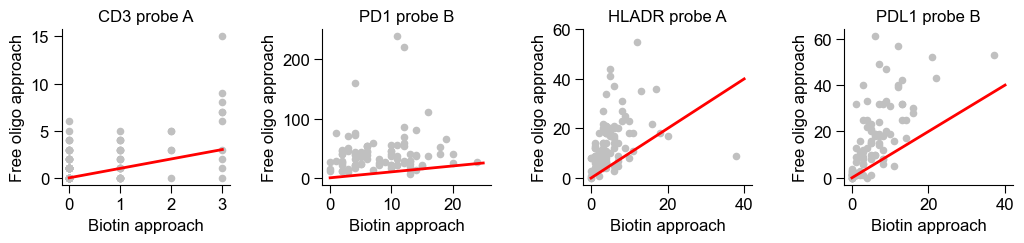

In [56]:
#%% Compare free oligo vs biotin     **Figure 3cdef**
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10.4,2.6))
ax[0].scatter(dge_real_T.loc["CD3:Biotin",:], dge_real_T.loc["CD3:free_oligo",:],
                c='silver', s=20)
ax[0].plot([0,3], [0,3], c='r', lw=2)  #y=x line#
ax[0].set_title("CD3 probe A")
ax[0].set_xticks(range(0,4,1))
ax[1].scatter(dge_real_T.loc["Biotin:PD1",:], dge_real_T.loc["free_oligo:PD1",:],
                c='silver', s=20)
ax[1].plot([0,25], [0,25], c='r', lw=2)
ax[1].set_title("PD1 probe B")
ax[2].scatter(dge_real_B.loc["HLADR:Biotin",:], dge_real_B.loc["HLADR:free_oligo",:],
                c='silver', s=20)
ax[2].plot([0,40], [0,40], c='r', lw=2)
ax[2].set_title("HLADR probe A")
ax[2].set_xticks(range(0,41,20))
ax[2].set_yticks(range(0,61,20))
ax[3].scatter(dge_real_B.loc["Biotin:PDL1",:], dge_real_B.loc["free_oligo:PDL1",:],
                c='silver', s=20)
ax[3].plot([0,40], [0,40], c='r', lw=2)
ax[3].set_xticks(range(0,41,20))
ax[3].set_title("PDL1 probe B")
for i in ax.flatten():
    i.set_xlabel("Biotin approach")
    i.set_ylabel("Free oligo approach")
fig.tight_layout(w_pad=1.9, h_pad=1.7)
sns.despine(fig=fig)
fig.savefig(myDir+"free_oligo_vs_biotin_Fig 3cdef.svg", bbox_inches='tight', pad_inches=0)

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2019.
2023-01-26 14:52:57     Start simulation
2023-01-26 14:52:59     Processed     10 cells
2023-01-26 14:53:00     Processed     20 cells
2023-01-26 14:53:01     Processed     30 cells
2023-01-26 14:53:02     Processed     40 cells
2023-01-26 14:53:03     Processed     50 cells
2023-01-26 14:53:04     Processed     60 cells
2023-01-26 14:53:05     Processed     70 cells
2023-01-26 14:53:06     Processed     80 cells
2023-01-26 14:53:07     Processed     90 cells
2023-01-26 14:53:08     Processed    100 cells
predictComplex done: Loop number 36, tolerance 0.93


/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/simulation_reproduce figures/ProxseqClasses.py:698: RuntimeWarning: divide by zero encountered in double_scalars
  t_intercept = (results.params[0] - intercept_cutoff)/results.bse[0]
/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/simulation_reproduce figures/ProxseqClasses.py:700: RuntimeWarning: invalid value encountered in double_scalars
  t_slope = (results.params[1] - slope_cutoff)/results.bse[1]


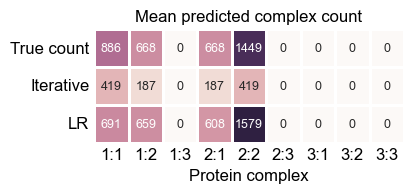

In [57]:
#Fig 4c
# This is similar to B cells, HLADR and PDL1   **Figure 4c**
num_complex = np.zeros((3,3))
num_complex[0,0] = 850
num_complex[0,1] = 750
num_complex[1,0] = 750
num_complex[1,1] = 1400
probeAB = np.array([20,15,2])

# Simulation
my_sim = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                        seed_num=2019, protein_variance=True, ligate_all=False)
my_sim.simulate(num_complex, probeAB, probeAB)

dge = PC.plaObject(my_sim.pla_count)
dge.predictComplex()
dge.predictComplex(method='lr', suffix='2', non_proximal_count=my_sim.non_proximal_count)
my_wls = dge.lr_params2

# Plot accuracy heatmap   **Figure 4c**
fig, ax = plt.subplots(figsize=(4.3,2.1))
temp = pd.DataFrame({'true':my_sim.complex_count.mean(axis=1),
                     '1':dge.complex_count.mean(axis=1),
                     '2':dge.complex_count2.mean(axis=1)})
sns.heatmap(temp.T, linewidths=1, ax=ax, annot=True, annot_kws={'fontsize':9},
            vmin=0, vmax=1600, cbar=False, fmt='.0f',
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True))
ax.set_xticks(np.arange(9)+0.5)
ax.set_xticklabels(temp.index, rotation=0)
ax.set_yticks(np.arange(3)+0.5)
ax.set_yticklabels(["True count","Iterative","LR"], rotation=0)
ax.tick_params(axis='both', length=0)
ax.set_xlabel("Protein complex")
ax.set_title("Mean predicted complex count")
fig.tight_layout()
fig.savefig(myDir+"heatmap_prediction_comparison_Fig 4c.svg", bbox_inches='tight', pad_inches=0)

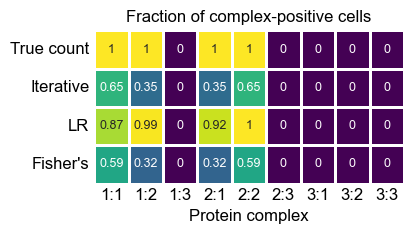

In [58]:
#Fig 4d
# Fisher's test     **Figure 4d**
dge.predictComplexFisher()
temp = pd.DataFrame({'true':(my_sim.complex_count>0).sum(axis=1),
                     '1':(dge.complex_count>0).sum(axis=1),
                     '2':(dge.complex_count2>0).sum(axis=1),
                     'fisher':(dge.complex_fisher<=0.05).sum(axis=1)})

fig, ax = plt.subplots(figsize=(4.3,2.5))
sns.heatmap(temp.T/dge.shape[1],
            linewidths=1, ax=ax, annot=True, annot_kws={'fontsize':9},
            vmin=0, vmax=1, cbar=False, fmt='.2g',
            cmap='viridis')
ax.set_xticks(np.arange(9)+0.5)
ax.set_xticklabels(temp.index, rotation=0)
ax.set_yticks(np.arange(4)+0.5)
ax.set_yticklabels(["True count","Iterative","LR","Fisher\'s"], rotation=0)
ax.tick_params(axis='both', length=0)
ax.set_xlabel("Protein complex")
ax.set_title("Fraction of complex-positive cells")
fig.tight_layout()
fig.savefig(myDir+"heatmap_prediction_fraction_comparison_Fig 4d.svg", bbox_inches='tight', pad_inches=0)

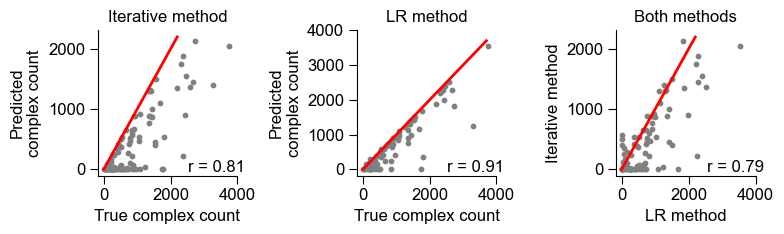

In [60]:
#Fig 4efg
# Show actual predict protein complex count    **Figure 4efg**
fig, ax = plt.subplots(ncols=3, figsize=(8,2.5))
ax[0].scatter(my_sim.complex_count.loc["1:1",:], dge.complex_count.loc["1:1",:],
              c='grey', s=10)
ax[0].plot([0,2200],[0,2200], c='red', lw=2)
pearsonr = stats.pearsonr(my_sim.complex_count.loc["1:1",:], dge.complex_count.loc["1:1",:])
ax[0].text(0.65,0.03, f"r = {pearsonr[0]:.2f}", transform=ax[0].transAxes)
ax[0].set_xticks(range(0,4001,2000))
ax[0].set_title("Iterative method")
ax[1].scatter(my_sim.complex_count.loc["1:1",:], dge.complex_count2.loc["1:1",:],
              c='grey', s=10)
ax[1].plot([0,3700],[0,3700], c='red', lw=2)
pearsonr = stats.pearsonr(my_sim.complex_count.loc["1:1",:], dge.complex_count2.loc["1:1",:])
ax[1].text(0.65,0.03, f"r = {pearsonr[0]:.2f}", transform=ax[1].transAxes)
ax[1].set_xticks(range(0,4001,2000))
ax[1].set_yticks(range(0,4001,1000))
ax[1].set_title("LR method")
ax[2].scatter(dge.complex_count2.loc["1:1",:], dge.complex_count.loc["1:1",:],
              c='grey', s=10)
ax[2].plot([0,2200],[0,2200], c='red', lw=2)
pearsonr = stats.pearsonr(dge.complex_count2.loc["1:1",:], dge.complex_count.loc["1:1",:])
ax[2].text(0.65,0.03, f"r = {pearsonr[0]:.2f}", transform=ax[2].transAxes)
ax[2].set_xticks(range(0,4001,2000))
ax[2].set_title("Both methods")
ax[2].set_ylabel("Iterative method")
ax[2].set_xlabel("LR method")
for i in range(2):
    ax[i].set_xlabel("True complex count")
    ax[i].set_ylabel("Predicted\ncomplex count")
fig.tight_layout(w_pad=0.8)
sns.despine(fig=fig)
fig.savefig(myDir+"scatter_prediction_Fig 4efg.svg", bbox_inches='tight', pad_inches=0)

In [16]:
#%% Protein complex comparison
# Plot heatmap of average predicted complex count in T cells
my_avg_T = pd.DataFrame({'mean':(pla_T.complex_count).mean(axis=1)})
my_avg_T['probeA'] = [s.split(':')[0] for s in my_avg_T.index]
my_avg_T['probeB'] = [s.split(':')[1] for s in my_avg_T.index]
my_avg_T = my_avg_T.pivot(index='probeA', columns='probeB', values='mean')

# Plot heatmap of average predicted complex count in B cells
my_avg_B = pd.DataFrame({'mean':(pla_B.complex_count).mean(axis=1)})
my_avg_B['probeA'] = [s.split(':')[0] for s in my_avg_B.index]
my_avg_B['probeB'] = [s.split(':')[1] for s in my_avg_B.index]
my_avg_B = my_avg_B.pivot(index='probeA', columns='probeB', values='mean')

# Plot heatmap of average predicted complex count in T cells
my_avg_T2 = pd.DataFrame({'mean':(pla_T.complex_count2).mean(axis=1)})
# Filter
my_avg_T2.loc[(lr_T["pval_intercept"].isna()),:] = 0
my_avg_T2['probeA'] = [s.split(':')[0] for s in my_avg_T2.index]
my_avg_T2['probeB'] = [s.split(':')[1] for s in my_avg_T2.index]
my_avg_T2 = my_avg_T2.pivot(index='probeA', columns='probeB', values='mean')

# Plot heatmap of average predicted complex count in B cells
my_avg_B2 = pd.DataFrame({'mean':(pla_B.complex_count2).mean(axis=1)})
# Filter
my_avg_B2.loc[(lr_B["pval_intercept"].isna()),:] = 0
my_avg_B2['probeA'] = [s.split(':')[0] for s in my_avg_B2.index]
my_avg_B2['probeB'] = [s.split(':')[1] for s in my_avg_B2.index]
my_avg_B2 = my_avg_B2.pivot(index='probeA', columns='probeB', values='mean')

#%% Try 1-sided fisher exact test
pla_T.predictComplexFisher()
pla_B.predictComplexFisher()

# Fraction of expressing cells
T_fisher_express = pd.DataFrame({'frac':(pla_T.complex_fisher<0.05).sum(axis=1)/pla_T.complex_fisher.shape[1]})
T_fisher_express['probeA'] = [s.split(':')[0] for s in T_fisher_express.index]
T_fisher_express['probeB'] = [s.split(':')[1] for s in T_fisher_express.index]
T_fisher_express = T_fisher_express.pivot(index='probeA', columns='probeB', values='frac')

# Fraction of expressing cells
B_fisher_express = pd.DataFrame({'frac':(pla_B.complex_fisher<0.05).sum(axis=1)/pla_B.complex_fisher.shape[1]})
B_fisher_express['probeA'] = [s.split(':')[0] for s in B_fisher_express.index]
B_fisher_express['probeB'] = [s.split(':')[1] for s in B_fisher_express.index]
B_fisher_express = B_fisher_express.pivot(index='probeA', columns='probeB', values='frac')

In [17]:
# Pearson correlation
pearsonr = pd.DataFrame(np.nan, index=pla_T.complex_count.index, columns=["T","B"])
for i in pearsonr.index:
    pearsonr.at[i,"T"] = stats.pearsonr(pla_T.complex_count.loc[i,:], pla_T.complex_count2.loc[i,:])[0]
    pearsonr.at[i,"B"] = stats.pearsonr(pla_B.complex_count.loc[i,:], pla_B.complex_count2.loc[i,:])[0]

# Convert to square data frame
pearsonr.loc[:,"probeA"] = [s.split(':')[0] for s in pearsonr.index]
pearsonr.loc[:,"probeB"] = [s.split(':')[1] for s in pearsonr.index]
pearsonr_T = pearsonr.pivot(index='probeA', columns='probeB', values='T')
pearsonr_B = pearsonr.pivot(index='probeA', columns='probeB', values='B')

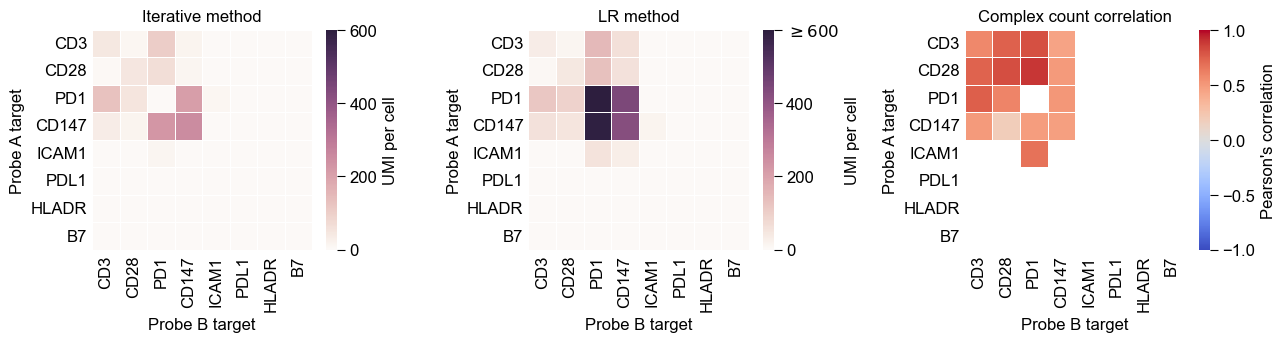

In [18]:
#Fig 5abc
my_order = ["CD3","CD28","PD1","CD147","ICAM1","PDL1","HLADR","B7"]
# Heatmap: compare iterative method vs LR method in T cells   **Figure 5abc**
my_ticklabels = [0,200,400,r"$\geq 600$"]
fig, ax = plt.subplots(ncols=3, figsize=(13,3.5))
sns.heatmap(my_avg_T.loc[my_order,my_order], ax=ax[0],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"UMI per cell",'ticks':range(0,601,200),'shrink':0.9},
            vmax=600)
ax[0].set_title("Iterative method")
sns.heatmap(my_avg_T2.loc[my_order,my_order], ax=ax[1],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"UMI per cell",'ticks':range(0,601,200),'shrink':0.9},
            vmax=600)
ax[1].collections[0].colorbar.set_ticklabels(my_ticklabels)
ax[1].set_title("LR method")
sns.heatmap(pearsonr_T.loc[my_order,my_order], ax=ax[2],   
            linewidths=0.5,
            square=True, vmax=1, vmin=-1, cmap='coolwarm',
            cbar_kws={'label':"Pearson's correlation",'shrink':0.9})
ax[2].set_title("Complex count correlation")
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(w_pad=1.5)
fig.savefig(myDir+"heatmap_comparison_Tcells_Fig 5abc.svg",
            bbox_inches='tight', pad_inches=0)

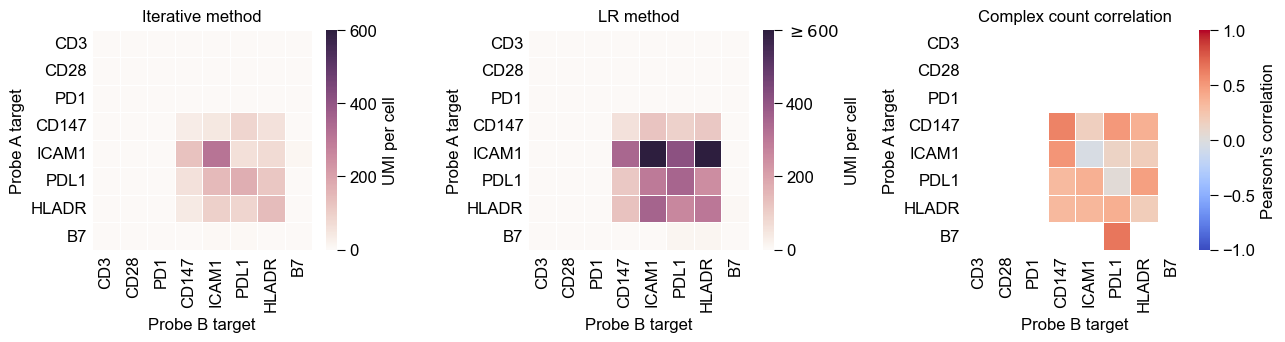

In [19]:
#Fig 5def
fig, ax = plt.subplots(ncols=3, figsize=(13,3.5))
sns.heatmap(my_avg_B.loc[my_order,my_order], ax=ax[0],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"UMI per cell",'ticks':range(0,601,200),'shrink':0.9},
            vmax=600)
ax[0].set_title("Iterative method")
sns.heatmap(my_avg_B2.loc[my_order,my_order], ax=ax[1],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"UMI per cell",'ticks':range(0,601,200),'shrink':0.9},
            vmax=600)
ax[1].collections[0].colorbar.set_ticklabels(my_ticklabels)
ax[1].set_title("LR method")
sns.heatmap(pearsonr_B.loc[my_order,my_order], ax=ax[2],
            linewidths=0.5,
            square=True, vmax=1, vmin=-1, cmap='coolwarm',
            cbar_kws={'label':"Pearson's correlation",'shrink':0.9})
ax[2].set_title("Complex count correlation")
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(w_pad=1.5)
fig.savefig(myDir+"heatmap_comparison_Bcells_Fig 5def.svg",
            bbox_inches='tight', pad_inches=0)

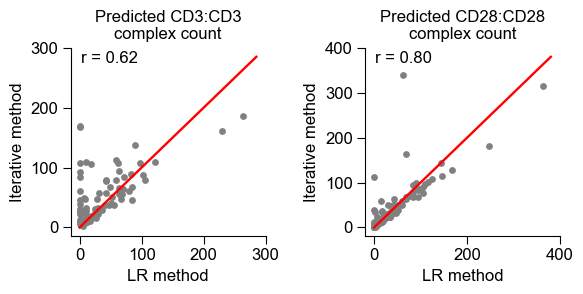

In [66]:
#Fig 5g
# T cells: Plot iterative method vs LR method prediction
fig, ax = plt.subplots(ncols=2, figsize=(6,3.1))
ax[0].scatter(pla_T.complex_count2.loc["CD3:CD3",:],
              pla_T.complex_count.loc["CD3:CD3",:], c='grey', s=15)
temp_x = np.array([0,285])
ax[0].plot(temp_x, temp_x, c="red", lw=1.7)
ax[0].text(0.05,0.92, f"r = {pearsonr_T.at['CD3','CD3']:.2f}", transform=ax[0].transAxes)
ax[0].set_title("Predicted CD3:CD3\ncomplex count")
ax[0].set_xticks(range(0,301,100))
ax[0].set_yticks(range(0,301,100))
ax[1].scatter(pla_T.complex_count2.loc["CD28:CD28",:],
              pla_T.complex_count.loc["CD28:CD28",:], c='grey', s=15)
temp_x = np.array([0,380])
ax[1].plot(temp_x, temp_x, c="red", lw=1.7)
ax[1].text(0.05,0.92, f"r = {pearsonr_T.at['CD28','CD28']:.2f}", transform=ax[1].transAxes)
ax[1].set_title("Predicted CD28:CD28\ncomplex count")
ax[1].set_xticks(range(0,401,200))
ax[1].set_yticks(range(0,401,100))
for i in ax:
    i.set_xlabel("LR method")
    i.set_ylabel("Iterative method")
    # i.set_aspect('auto')
fig.tight_layout(w_pad=1.5)
sns.despine(fig=fig)
fig.savefig(myDir+"Tcells_method_12_example_Fig 5g.svg",
            bbox_inches='tight', pad_inches=0)

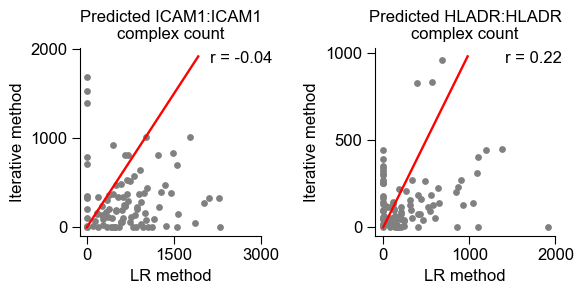

In [67]:
fig, ax = plt.subplots(ncols=2, figsize=(6,3.1))
ax[0].scatter(pla_B.complex_count2.loc["ICAM1:ICAM1",:],
              pla_B.complex_count.loc["ICAM1:ICAM1",:], c='grey', s=15)
temp_x = np.array([0,1920])
ax[0].plot(temp_x, temp_x, c="red", lw=1.7)
ax[0].text(0.72,0.92, f"r = {pearsonr_B.at['ICAM1','ICAM1']:.2f}", transform=ax[0].transAxes)
ax[0].set_title("Predicted ICAM1:ICAM1\ncomplex count")
ax[0].set_xticks(range(0,3001,1500))
ax[0].set_yticks(range(0,2001,1000))
ax[1].scatter(pla_B.complex_count2.loc["HLADR:HLADR",:],
              pla_B.complex_count.loc["HLADR:HLADR",:], c='grey', s=15)
temp_x = np.array([0,980])
ax[1].plot(temp_x, temp_x, c="red", lw=1.7)
ax[1].text(0.72,0.92, f"r = {pearsonr_B.at['HLADR','HLADR']:.2f}", transform=ax[1].transAxes)
ax[1].set_title("Predicted HLADR:HLADR\ncomplex count")
ax[1].set_xticks(range(0,2001,1000))
ax[1].set_xlim(-100,2000)
ax[1].set_yticks(range(0,1001,500))
for i in ax:
    i.set_xlabel("LR method")
    i.set_ylabel("Iterative method")
    # i.set_aspect('auto')
fig.tight_layout(w_pad=1.5)
sns.despine(fig=fig)
fig.savefig(myDir+"Bcells_method_12_example_Fig 5h.svg",
            bbox_inches='tight', pad_inches=0)

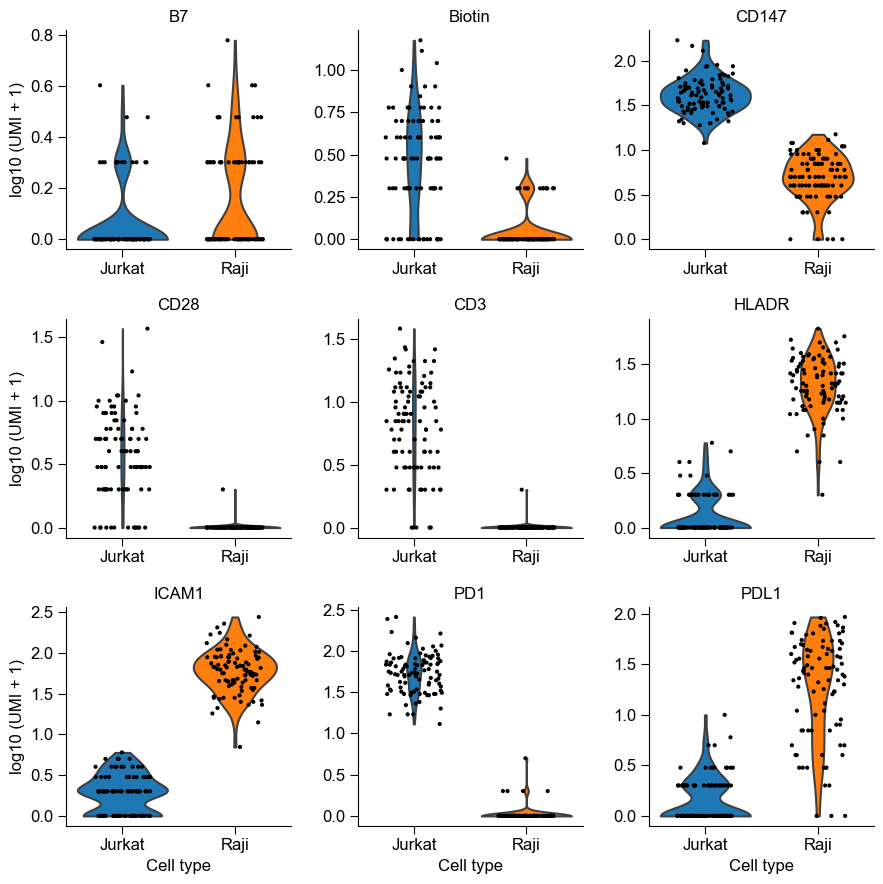

In [68]:
#Fig S1
temp1 = pd.DataFrame(0, index=pla_T.protein_count.columns, columns=pla_T.protein_count.index)
for i in temp1.columns:
    temp1.loc[:,i] = np.log10(pla_T.non_proximal_count.loc[f"{i}_A",:] + pla_T.non_proximal_count.loc[f"{i}_B",:]+1)

temp1.loc[:,"type"] = "Jurkat"
temp2 = pd.DataFrame(0, index=pla_B.protein_count.columns, columns=pla_B.protein_count.index)
for i in temp2.columns:
    temp2.loc[:,i] = np.log10(pla_B.non_proximal_count.loc[f"{i}_A",:] + pla_B.non_proximal_count.loc[f"{i}_B",:]+1)
temp2.loc[:,"type"] = "Raji"
temp = pd.concat((temp1, temp2), axis=0)

# Violint plot       **Figure S1**
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
np.random.seed(1)
for counter, val in enumerate(pla_T.protein_count.index):
    row = counter // 3
    col = counter % 3
    sns.violinplot(y=val, x="type", data=temp, ax=ax[row,col],
                   cut=0, saturation=100, inner=None)
    sns.stripplot(y=val, x="type", data=temp, ax=ax[row,col],
                  jitter=0.25, color='k', size=3)
    ax[row,col].set_title(val)
    if row == 2:
        ax[row,col].set_xlabel("Cell type")
    else:
        ax[row,col].set_xlabel("")
    if col == 0:
        ax[row,col].set_ylabel("log10 (UMI + 1)")
    else:
        ax[row,col].set_ylabel("")
fig.tight_layout(w_pad=1.3, h_pad=1.3)
sns.despine(fig=fig)
fig.savefig(myDir+"violin_non_proximal_count_Fig S1.svg", bbox_inches='tight', pad_inches=0)

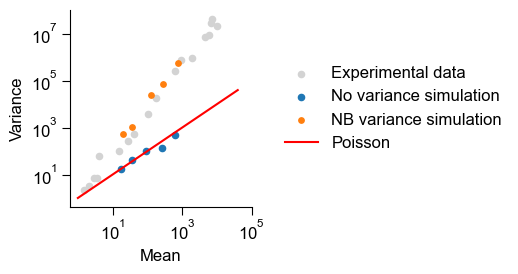

In [69]:
#Fig S2a
fig, ax = plt.subplots(figsize=(5.6,2.9))
ax.scatter(pla_T.protein_count.mean(axis=1), pla_T.protein_count.var(axis=1),
           color='lightgrey', s=20, label="Experimental data")
ax.scatter(pla_B.protein_count.mean(axis=1), pla_B.protein_count.var(axis=1),
           color='lightgrey', s=20)
ax.scatter(dge0.protein_count.mean(axis=1), dge0.protein_count.var(axis=1),
           s=20, label="No variance simulation")
ax.scatter(dge1.protein_count.mean(axis=1), dge1.protein_count.var(axis=1),
           s=15, label="NB variance simulation")
ax.plot([1e0,10**4.6],[1e0,10**4.6], c='red', label="Poisson")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mean")
ax.set_ylabel("Variance")
ax.set_xticks([1e1,1e3,1e5])
sns.despine(fig=fig)
handles, labels = ax.get_legend_handles_labels()
handles2 = handles[1:]
handles2.append(handles[0])
labels2 = labels[1:]
labels2.append(labels[0])
ax.legend(handles=handles2, labels=labels2, loc='center left',
          bbox_to_anchor=(1.1, 0.5), frameon=False)
fig.tight_layout()
fig.savefig(myDir+"real_simulation_protein_poisson_Fig S2a.svg", bbox_inches='tight', pad_inches=0)

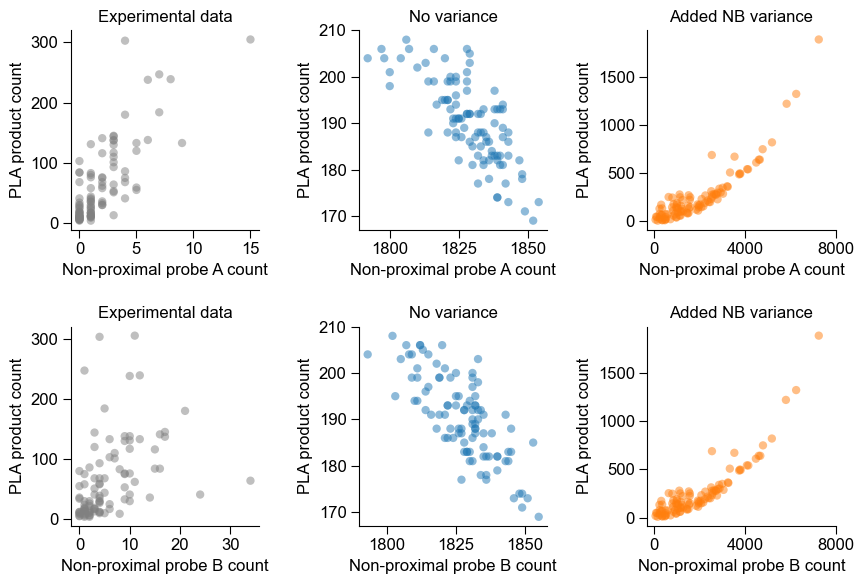

In [70]:
#Fig S2bcdefg
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8.8,6))
for row, i in enumerate(["A","B"]):
    ax[row,0].scatter(pla_T.non_proximal_count.loc[f"CD3_{i}",:], pla_T.pla_count.loc["CD3:CD3",:],
                  alpha=0.5, edgecolor='None', c='grey')
    ax[row,0].set_title("Experimental data")
    ax[row,1].scatter(sim0.non_proximal_count.loc[f"1_{i}",:], sim0.pla_count.loc["1:1",:],
                  alpha=0.5, edgecolor='None', c='tab:blue')
    ax[row,1].set_title("No variance")
    ax[row,1].set_yticks(range(170,211,10))
    ax[row,2].scatter(sim1.non_proximal_count.loc[f"1_{i}",:], sim1.pla_count.loc["1:1",:],
                  alpha=0.5, edgecolor='None', c='tab:orange')
    ax[row,2].set_title("Added NB variance")
    for col in range(3):
        ax[row,col].set_xlabel(f"Non-proximal probe {i} count")
        ax[row,col].set_ylabel("PLA product count")
ax[0,0].set_xticks(range(0,16,5))
ax[0,2].set_xticks(range(0,8001,4000))
ax[1,0].set_xticks(range(0,31,10))
ax[1,2].set_xticks(range(0,8001,4000))
sns.despine(fig=fig)
fig.tight_layout(w_pad=1.8, h_pad=1.7)
fig.savefig(myDir+"pla_vs_non_proximal_Fig S2bcdefg.svg", bbox_inches='tight', pad_inches=0)

In [78]:
num_complex = np.zeros((3,3))
probeA = [2,20.1,0.6]
probeB = [5.7,41.6,0.1]
my_simS3 = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                        seed_num=2019, protein_variance=True, ligate_all=False)
my_simS3.simulate(num_complex, probeA, probeB)

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2019.
2023-01-27 10:20:00     Start simulation
2023-01-27 10:20:00     Processed     10 cells
2023-01-27 10:20:00     Processed     20 cells
2023-01-27 10:20:00     Processed     30 cells
2023-01-27 10:20:00     Processed     40 cells
2023-01-27 10:20:00     Processed     50 cells
2023-01-27 10:20:00     Processed     60 cells
2023-01-27 10:20:00     Processed     70 cells
2023-01-27 10:20:00     Processed     80 cells
2023-01-27 10:20:00     Processed     90 cells
2023-01-27 10:20:00     Processed    100 cells


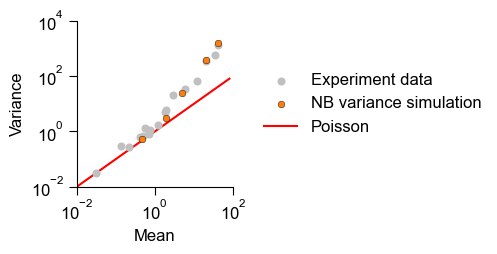

In [80]:
#Fig S3a
fig, ax = plt.subplots(figsize=(5.4,2.7))
ax.scatter(pla_T.non_proximal_count.mean(axis=1), pla_T.non_proximal_count.var(axis=1),
           c='silver', s=23, zorder=1, label="Experiment data") # ec='k', linewidths=0.5,
ax.scatter(my_simS3.non_proximal_count.mean(axis=1), my_simS3.non_proximal_count.var(axis=1),
           c='tab:orange', ec='k', linewidths=0.3, s=23, zorder=2,
           label="NB variance simulation")
ax.plot([1e-2,8e1], [1e-2,8e1], c='red', lw=1.5, zorder=0,
        label="Poisson")  #y=x#
handles, labels = ax.get_legend_handles_labels()
handles.append(handles[0])
labels.append(labels[0])
ax.legend(handles=handles[1:], labels=labels[1:],
          loc='center left', bbox_to_anchor=(1.1,0.5), frameon=False)
ax.set_xlabel("Mean")
ax.set_ylabel("Variance")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2, 1e2)
ax.set_ylim(1e-2, 1e4)
sns.despine(fig=fig)
fig.tight_layout()
fig.savefig(myDir+"non_proximal_mean_var_real_sim_Fig S3a.svg",
            bbox_inches='tight', pad_inches=0)

CD3_A KS test: 0.89317
PD1_A KS test: 0.97157
PDL1_A KS test: 1.00000
CD3_B KS test: 0.16963
PD1_B KS test: 0.00881
PDL1_B KS test: 0.84202


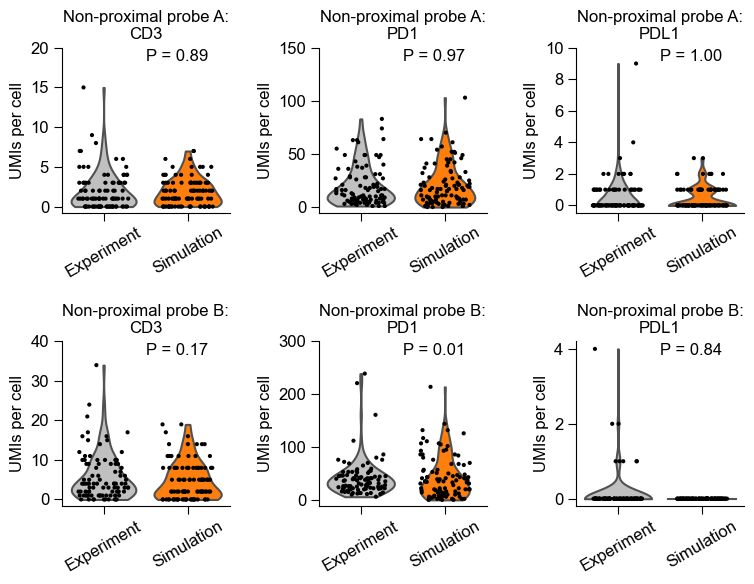

In [102]:
#Fig S3bcdefg
# Prepare data for violin plot    
temp1 = pla_T.non_proximal_count.loc[["PD1_A","PDL1_A","CD3_A","PD1_B","PDL1_B","CD3_B"],:].T.copy()
temp1['sample'] = "Experiment"
temp2 = my_simS3.non_proximal_count.T.copy()
temp2['3_B'] = 0
temp2_cols = []
for i in temp2.columns:
    j = i.split('_')
    if j[0] == "1":
        temp2_cols.append(f"CD3_{j[1]}")
    elif j[0] == "2":
        temp2_cols.append(f"PD1_{j[1]}")
    else:
        temp2_cols.append(f"PDL1_{j[1]}")
temp2.columns = temp2_cols
temp2['sample'] = "Simulation"
temp3 = pd.concat([temp1,temp2], axis=0)

# Violin plot              **Figure S3**
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7.7,6))  
np.random.seed(1)
for counter, value in enumerate(["CD3_A","PD1_A","PDL1_A","CD3_B","PD1_B","PDL1_B"]):
    row = counter // 3
    col = counter % 3
    sns.violinplot(data=temp3, x='sample', y=value, ax=ax[row,col], saturation=1,
                   cut=0, inner=None, palette=['silver','tab:orange'])
    sns.stripplot(data=temp3, x='sample', y=value, ax=ax[row,col],
                  jitter=0.3, color='k', size=3)
    ax[row,col].set_xlabel('')
    ax[row,col].set_ylabel("UMIs per cell")
    ax[row,col].set_xticks(range(2))
    ax[row,col].set_xticklabels(["Experiment","Simulation"], rotation=30)
    ks = stats.kstest(temp1[value], temp2[value])
    ax[row,col].text(0.5,0.92, f"P = {ks[1]:.2f}", transform=ax[row,col].transAxes)
    print(f"{value} KS test: {ks[1]:.5f}")
ax[0,0].set_title("Non-proximal probe A:\nCD3")
ax[0,1].set_title("Non-proximal probe A:\nPD1")
ax[0,2].set_title("Non-proximal probe A:\nPDL1")
ax[1,0].set_title("Non-proximal probe B:\nCD3")
ax[1,1].set_title("Non-proximal probe B:\nPD1")
ax[1,2].set_title("Non-proximal probe B:\nPDL1")
ax[0,0].set_yticks(range(0,21,5))
ax[0,1].set_yticks(range(0,151,50))
ax[0,2].set_yticks(range(0,11,2))
ax[1,0].set_yticks(range(0,41,10))
ax[1,1].set_yticks(range(0,301,100))
sns.despine(fig=fig)
fig.tight_layout(w_pad=1.7, h_pad=1.4)
fig.savefig(myDir+"non_proximal_violin_real_sim_Fig S3bcdefg.svg",
            bbox_inches='tight', pad_inches=0)

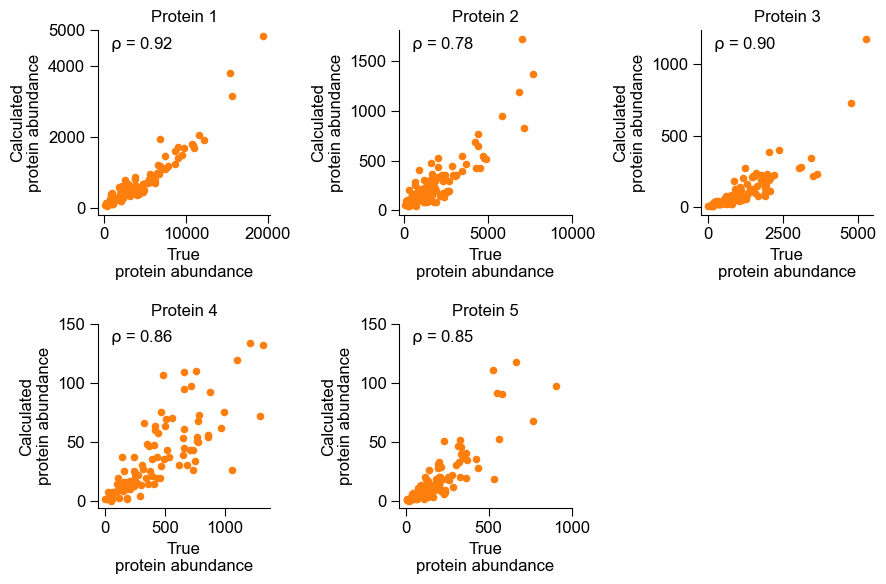

In [118]:
#FigS4
dge1.calculateProteinCount()

tempA = np.array([s.split(':')[0] for s in sim1.complex_count.index])
tempB = np.array([s.split(':')[1] for s in sim1.complex_count.index])
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,6))
for i in range(5):
    row = i // 3
    col = i % 3
    true_protein = (sim1.probe_count.loc[f"{i+1}_A",:]+sim1.probe_count.loc[f"{i+1}_B",:]+
                    (sim1.complex_count.loc[tempA==f"{i+1}",:]+sim1.complex_count.loc[tempB==f"{i+1}",:]).sum(axis=0))
    ax[row,col].scatter(true_protein, dge1.protein_count.loc[f"{i+1}",:],
                        c= 'tab:orange', s=20)
    rho = stats.spearmanr(true_protein, dge1.protein_count.loc[f"{i+1}",:])
    ax[row,col].text(0.07,0.9, r"$\mathrm{\rho}$ = "+f"{rho[0]:.2f}", transform=ax[row,col].transAxes)
    ax[row,col].set_xlabel("True\nprotein abundance")
    ax[row,col].set_ylabel("Calculated\nprotein abundance")
    ax[row,col].set_title(f"Protein {i+1}")
ax[0,0].set_xticks(range(0,20001,10000))
ax[0,0].set_yticks([0,2000,4000,5000])
ax[0,0].set_ylim(-200,5000)
ax[0,1].set_xticks(range(0,10001,5000))
ax[1,0].set_xticks(range(0,1500,500))
ax[1,0].set_yticks([0,50,100,150])
ax[1,1].set_xticks(range(0,1001,500))
ax[1,1].set_yticks(range(0,151,50))
ax[0,2].set_xticks(range(0,5100,2500))
ax[0,2].set_yticks(range(0,1250,500))
ax[1,2].axis('off')
sns.despine(fig=fig)
fig.tight_layout(h_pad=1.4)
# fig.savefig(myDir+"protein_count_accuracy.svg", bbox_inches='tight', pad_inches=0)
fig.savefig(myDir+"protein_count_accuracy_Fig S4.svg", bbox_inches='tight', pad_inches=0, dpi=400)

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2019.
2023-01-27 11:25:16     Start simulation
2023-01-27 11:25:17     Processed     10 cells
2023-01-27 11:25:17     Processed     20 cells
2023-01-27 11:25:17     Processed     30 cells
2023-01-27 11:25:17     Processed     40 cells
2023-01-27 11:25:18     Processed     50 cells
2023-01-27 11:25:18     Processed     60 cells
2023-01-27 11:25:18     Processed     70 cells
2023-01-27 11:25:19     Processed     80 cells
2023-01-27 11:25:19     Processed     90 cells
2023-01-27 11:25:19     Processed    100 cells


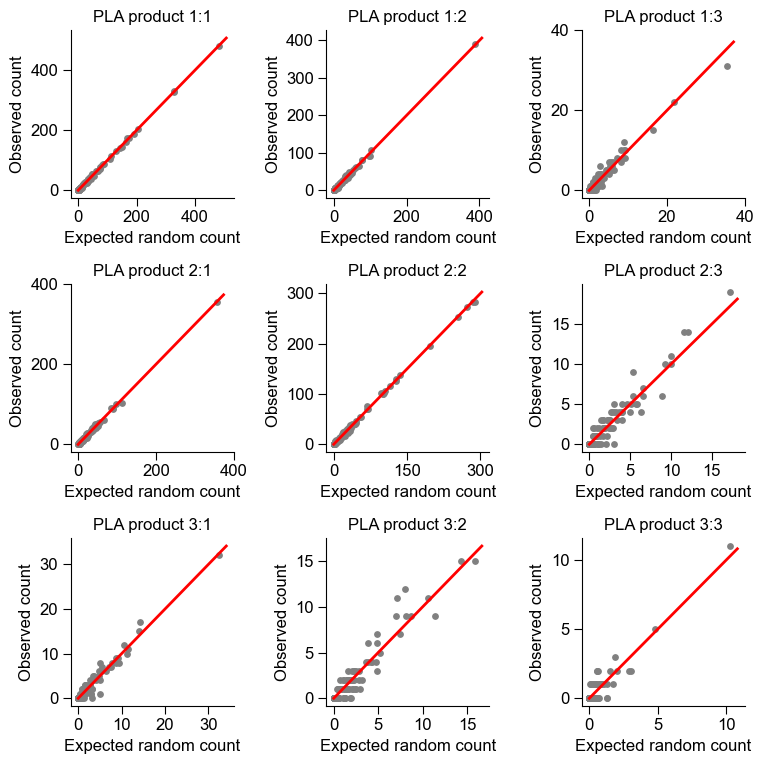

In [120]:
#Fig S5a
num_complex = np.zeros((3,3))
probeA = np.array([1000,1000,100])
probeB = np.array([1000,1000,100])
my_simS5 = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                        seed_num=2019, protein_variance=True,  ligate_all=False)
my_simS5.simulate(num_complex, probeA, probeB)
dge = PC.plaObject(my_simS5.pla_count)
dge.calculateExpected()
# Plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7.8,7.8), tight_layout=True)
for counter, i in enumerate(dge.pla_count.index):
    row_i = int(counter / 3)
    col_i = int(counter % 3)
    ax[row_i,col_i].scatter(dge.pla_expected.loc[i,:], dge.pla_count.loc[i,:], c='grey', s=15)
    _, xmax = ax[row_i,col_i].get_xlim()
    ax[row_i,col_i].plot([0,xmax],[0,xmax], 'red', lw=2)
    ax[row_i,col_i].set_xlabel("Expected random count")
    ax[row_i,col_i].set_ylabel("Observed count")
    ax[row_i,col_i].set_title(f"PLA product {i}")
sns.despine(fig=fig)
ax[0,2].set_xticks(range(0,41,20))
ax[0,2].set_yticks(range(0,41,20))
ax[1,0].set_xticks(range(0,401,200))
ax[1,0].set_yticks(range(0,401,200))
ax[1,1].set_xticks(range(0,301,150))
ax[1,2].set_xticks(range(0,16,5))
ax[2,0].set_xticks(range(0,31,10))
ax[2,1].set_xticks(range(0,16,5))
ax[2,2].set_yticks(range(0,11,5))
fig.savefig(myDir+"expected_observed_1_Fig S5a.png", bbox_inches='tight', pad_inches=0, dpi=600)

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2019.
2023-01-27 11:26:41     Start simulation
2023-01-27 11:26:42     Processed     10 cells
2023-01-27 11:26:42     Processed     20 cells
2023-01-27 11:26:42     Processed     30 cells
2023-01-27 11:26:43     Processed     40 cells
2023-01-27 11:26:43     Processed     50 cells
2023-01-27 11:26:44     Processed     60 cells
2023-01-27 11:26:44     Processed     70 cells
2023-01-27 11:26:44     Processed     80 cells
2023-01-27 11:26:44     Processed     90 cells
2023-01-27 11:26:45     Processed    100 cells


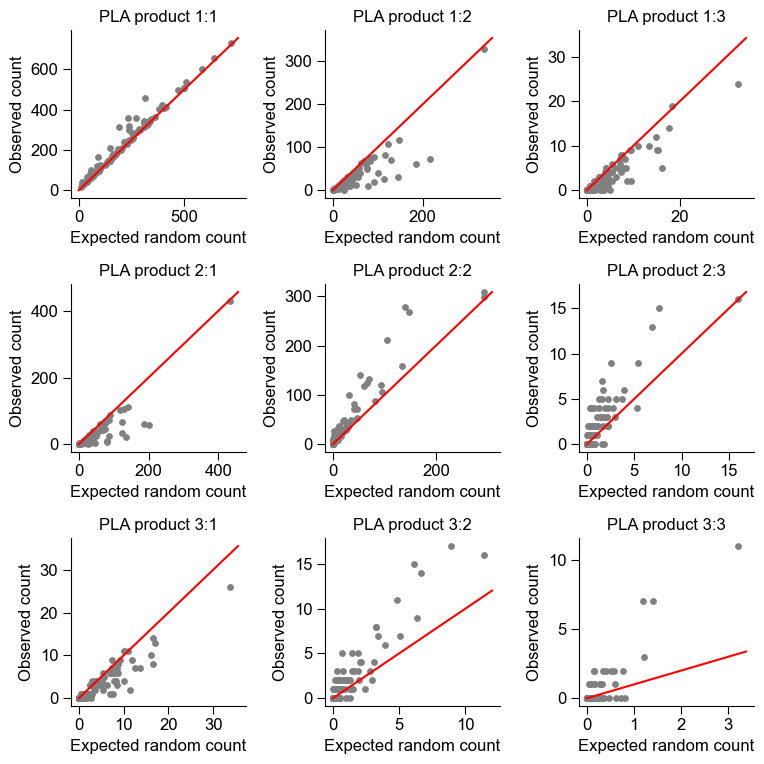

In [121]:
#Fig S5b
num_complex = np.zeros((3,3))
num_complex[0,0] = 200
probeA = np.array([1000,1000,100])
probeB = np.array([1000,1000,100])
my_simS5b = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist,
                        seed_num=2019, protein_variance=True,  ligate_all=False)
my_simS5b.simulate(num_complex, probeA, probeB)
dge = PC.plaObject(my_simS5b.pla_count)
dge.calculateExpected()
# Plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7.8,7.8), tight_layout=True)
for counter, i in enumerate(dge.pla_count.index):
    row_i = int(counter / 3)
    col_i = int(counter % 3)
    ax[row_i,col_i].scatter(dge.pla_expected.loc[i,:], dge.pla_count.loc[i,:], c='grey', s=15)
    _, xmax = ax[row_i,col_i].get_xlim()
    ax[row_i,col_i].plot([0,xmax],[0,xmax], 'red')
    ax[row_i,col_i].set_xlabel("Expected random count")
    ax[row_i,col_i].set_ylabel("Observed count")
    ax[row_i,col_i].set_title(f"PLA product {i}")
sns.despine(fig=fig)
ax[1,2].set_xticks(range(0,16,5))
ax[2,0].set_xticks(range(0,31,10))
ax[2,2].set_xticks(range(0,4,1))
ax[2,2].set_yticks(range(0,11,5))
fig.savefig(myDir+"expected_observed_2_Fig S5b.png", bbox_inches='tight', pad_inches=0, dpi=600)

In [ ]:
#Fig S6
myA1 = "PD1"
myB1 = "PD1"
exog1 = pd.DataFrame({"AB":pla_T.non_proximal_count.loc[f"{myA1}_A",:]*pla_T.non_proximal_count.loc[f"{myB1}_B",:]})
exog1 = sm.add_constant(exog1)
ols1 = sm.OLS(pla_T.pla_count.loc[f"{myA1}:{myB1}",:], exog1).fit()

myA2 = "HLADR"
myB2 = "HLADR"
exog2 = pd.DataFrame({"AB":pla_B.non_proximal_count.loc[f"{myA2}_A",:]*pla_B.non_proximal_count.loc[f"{myB2}_B",:]})
exog2 = sm.add_constant(exog2)
ols2 = sm.OLS(pla_B.pla_count.loc[f"{myA2}:{myB2}",:], exog2).fit()

# Plot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7.5,5.8))
ax[0,0].scatter(exog1['AB'], pla_T.pla_count.loc[f"{myA1}:{myB1}",:], c='grey', s=15)
tempx = np.array([0,5300])
ax[0,0].plot(tempx, tempx*lr_T.loc[f"{myA1}:{myB1}",'slope']+lr_T.loc[f"{myA1}:{myB1}",'intercept'], 
             c='tab:orange', lw=2)
ax[0,0].plot(tempx, tempx*ols1.params['AB']+ols1.params['const'], 
             c='tab:blue', lw=2)
ax[0,0].set_title(f"{myA1}:{myB1}")
ax[0,0].set_yticks(range(0,10001,2500))
ax[0,0].legend(["WLS","OLS"], loc="center left",
               bbox_to_anchor=(1.02,0.5))
ax[0,1].scatter(ols1.fittedvalues, ols1.resid, c='grey', s=15)
ax[0,1].set_xticks(range(0,6001,2000))
ax[0,1].set_title(f"{myA1}:{myB1}")
ax[1,0].scatter(exog2['AB'], pla_B.pla_count.loc[f"{myA2}:{myB2}",:], c='grey', s=15)
tempx = np.array([0,800])
ax[1,0].plot(tempx, tempx*lr_B.loc[f"{myA2}:{myB2}",'slope']+lr_B.loc[f"{myA2}:{myB2}",'intercept'], 
             c='tab:orange', lw=2)
ax[1,0].plot(tempx, tempx*ols2.params['AB']+ols2.params['const'],
             c='tab:blue', lw=2)
ax[1,0].set_title(f"{myA2}:{myB2}")
ax[1,0].set_xticks(range(0,751,250))
ax[1,0].legend(["WLS","OLS"], loc="center left",
               bbox_to_anchor=(1.02,0.5))
ax[1,1].scatter(ols2.fittedvalues, ols2.resid, c='grey', s=15)
ax[1,1].set_xticks(range(0,3001,1000))
ax[1,1].set_title(f"{myA2}:{myB2}")
for i in range(2):
    ax[i,0].set_xlabel("Random ligation amount")
    ax[i,0].set_ylabel("PLA product count")
    ax[i,1].set_xlabel("Fitted values")
    ax[i,1].set_ylabel("Residual")
sns.despine(fig=fig)
fig.tight_layout(h_pad=1.7, w_pad=1.9)
fig.savefig(myDir+"heteroscedasticity_real_data_Fig S6.svg",
            bbox_inches='tight', pad_inches=0)

NameError: name 'pd' is not defined

In [132]:
# Plot heatmap of average predicted complex count in T cells
my_frac_T1 = pd.DataFrame({'mean':(pla_T.complex_count/pla_T.pla_count).mean(axis=1)})
# Filter
my_frac_T1.loc[(lr_T["pval_intercept"].isna()),:] = 0
my_frac_T1['probeA'] = [s.split(':')[0] for s in my_frac_T1.index]
my_frac_T1['probeB'] = [s.split(':')[1] for s in my_frac_T1.index]
my_frac_T1 = my_frac_T1.pivot(index='probeA', columns='probeB', values='mean')

# Plot heatmap of average predicted complex count in B cells
my_frac_B1 = pd.DataFrame({'mean':(pla_B.complex_count/pla_B.pla_count).mean(axis=1)})
# Filter
my_frac_B1.loc[(lr_B["pval_intercept"].isna()),:] = 0
my_frac_B1['probeA'] = [s.split(':')[0] for s in my_frac_B1.index]
my_frac_B1['probeB'] = [s.split(':')[1] for s in my_frac_B1.index]
my_frac_B1 = my_frac_B1.pivot(index='probeA', columns='probeB', values='mean')

# Plot heatmap of average predicted complex count in T cells  **Figure S7ab**
my_frac_T2 = pd.DataFrame({'mean':(pla_T.complex_count2/pla_T.pla_count).mean(axis=1)})
# Filter
my_frac_T2.loc[(lr_T["pval_intercept"].isna()),:] = 0
my_frac_T2['probeA'] = [s.split(':')[0] for s in my_frac_T2.index]
my_frac_T2['probeB'] = [s.split(':')[1] for s in my_frac_T2.index]
my_frac_T2 = my_frac_T2.pivot(index='probeA', columns='probeB', values='mean')

# Plot heatmap of average predicted complex count in B cells   **Figure S7de**
my_frac_B2 = pd.DataFrame({'mean':(pla_B.complex_count2/pla_B.pla_count).mean(axis=1)})
# Filter
my_frac_B2.loc[(lr_B["pval_intercept"].isna()),:] = 0
my_frac_B2['probeA'] = [s.split(':')[0] for s in my_frac_B2.index]
my_frac_B2['probeB'] = [s.split(':')[1] for s in my_frac_B2.index]
my_frac_B2 = my_frac_B2.pivot(index='probeA', columns='probeB', values='mean')

# Plot comparison
my_order = ["CD3","CD28","PD1","CD147","ICAM1","PDL1","HLADR","B7","Biotin"]

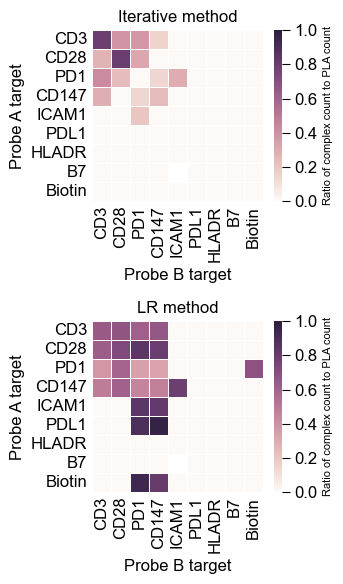

In [154]:
#Fig S7ab
# Heatmap: compare iterative method vs LR method in T cells  *Figure S7ab**
fig, ax = plt.subplots(nrows=2, figsize=(3.5,6))
sns.heatmap(my_frac_T1.loc[my_order,my_order], ax=ax[0],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"Ratio of complex count to PLA count",'shrink':1},
            vmax=1)
ax[0].set_title("Iterative method")
ax[0].figure.axes[-1].yaxis.label.set_size(8)
sns.heatmap(my_frac_T2.loc[my_order,my_order], ax=ax[1],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"Ratio of complex count to PLA count",'shrink':1},
            vmax=1)
# ax[1].collections[0].colorbar.set_ticklabels(my_ticklabels)
ax[1].set_title("LR method")
ax[1].figure.axes[-1].yaxis.label.set_size(8)
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(w_pad=1.5)
fig.savefig(myDir+"Ratio of complex count to PLA count_T cells.svg",
            bbox_inches='tight', pad_inches=0)

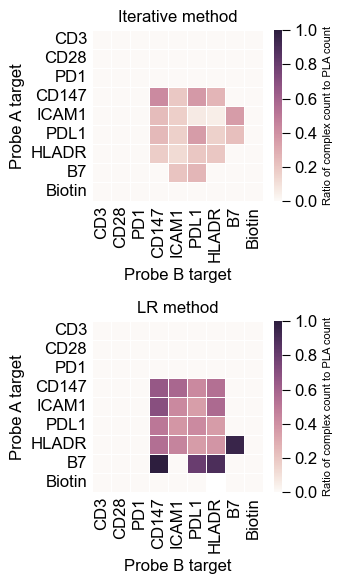

In [155]:
#Fig S7de
# Heatmap: compare iterative method vs LR method in B cells    **Figure S7de**
fig, ax = plt.subplots(nrows=2, figsize=(3.5,6))
sns.heatmap(my_frac_B1.loc[my_order,my_order], ax=ax[0],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"Ratio of complex count to PLA count",'shrink':1},
            vmax=1)
ax[0].set_title("Iterative method")
ax[0].figure.axes[-1].yaxis.label.set_size(8)
sns.heatmap(my_frac_B2.loc[my_order,my_order], ax=ax[1],
            linewidths=0.5, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            cbar_kws={'label':"Ratio of complex count to PLA count",'shrink':1},
            vmax=1)
# ax[1].collections[0].colorbar.set_ticklabels(my_ticklabels)
ax[1].set_title("LR method")
ax[1].figure.axes[-1].yaxis.label.set_size(8)
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(w_pad=1.5)
fig.savefig(myDir+"Ratio of complex count to PLA count_B cells.svg",
            bbox_inches='tight', pad_inches=0)

In [20]:
#%% Compare fraction of expressing cells   
T_1_express = pd.DataFrame({'frac':(pla_T.complex_count>0).sum(axis=1)})/pla_T.shape[1]
T_1_express['probeA'] = [s.split(':')[0] for s in T_1_express.index]
T_1_express['probeB'] = [s.split(':')[1] for s in T_1_express.index]
T_1_express = T_1_express.pivot(index='probeA', columns='probeB', values='frac')

T_2_express = pd.DataFrame({'frac':(pla_T.complex_count2>0).sum(axis=1)})/pla_T.shape[1]
T_2_express['probeA'] = [s.split(':')[0] for s in T_2_express.index]
T_2_express['probeB'] = [s.split(':')[1] for s in T_2_express.index]
T_2_express = T_2_express.pivot(index='probeA', columns='probeB', values='frac')

B_1_express = pd.DataFrame({'frac':(pla_B.complex_count>0).sum(axis=1)})/pla_B.shape[1]
B_1_express['probeA'] = [s.split(':')[0] for s in B_1_express.index]
B_1_express['probeB'] = [s.split(':')[1] for s in B_1_express.index]
B_1_express = B_1_express.pivot(index='probeA', columns='probeB', values='frac')

B_2_express = pd.DataFrame({'frac':(pla_B.complex_count2>0).sum(axis=1)})/pla_B.shape[1]
B_2_express['probeA'] = [s.split(':')[0] for s in B_2_express.index]
B_2_express['probeB'] = [s.split(':')[1] for s in B_2_express.index]
B_2_express = B_2_express.pivot(index='probeA', columns='probeB', values='frac')

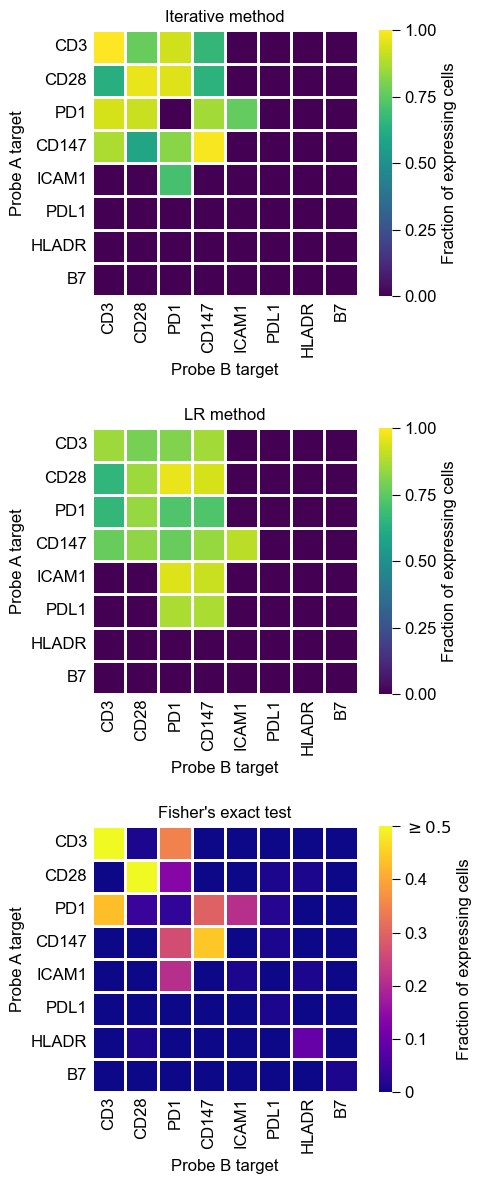

In [21]:
#Fig S7abc
# Fisher's test: T cells    **Figure S7c**
my_ticklabels = [0,0.1,0.2,0.3,0.4,r"$\geq 0.5$"]
fig, ax = plt.subplots(nrows=3, figsize=(5.2,12))
sns.heatmap(T_1_express.loc[my_order,my_order], ax=ax[0],
            linewidths=1, square=True,
            cmap='viridis',
            vmax=1, cbar_kws={'label':"Fraction of expressing cells",
                              'ticks':np.arange(0,1.1,0.25)})
ax[0].set_title("Iterative method")
sns.heatmap(T_2_express.loc[my_order,my_order], ax=ax[1],
            linewidths=1, square=True,
            cmap='viridis',
            vmax=1, cbar_kws={'label':"Fraction of expressing cells",
                              'ticks':np.arange(0,1.1,0.25)})
ax[1].set_title("LR method")
sns.heatmap(T_fisher_express.loc[my_order,my_order], ax=ax[2],
            linewidths=1, square=True,
            cmap='plasma',
            vmax=0.5, cbar_kws={'label':"Fraction of expressing cells",
                                'ticks':np.arange(0,0.55,0.1)})
ax[2].collections[0].colorbar.set_ticklabels(my_ticklabels)
ax[2].set_title("Fisher's exact test")
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(h_pad=1.8)
fig.savefig(myDir+"Tcells_heatmap_expressing_fraction_Fig S7abc.svg",
            bbox_inches='tight', pad_inches=0)

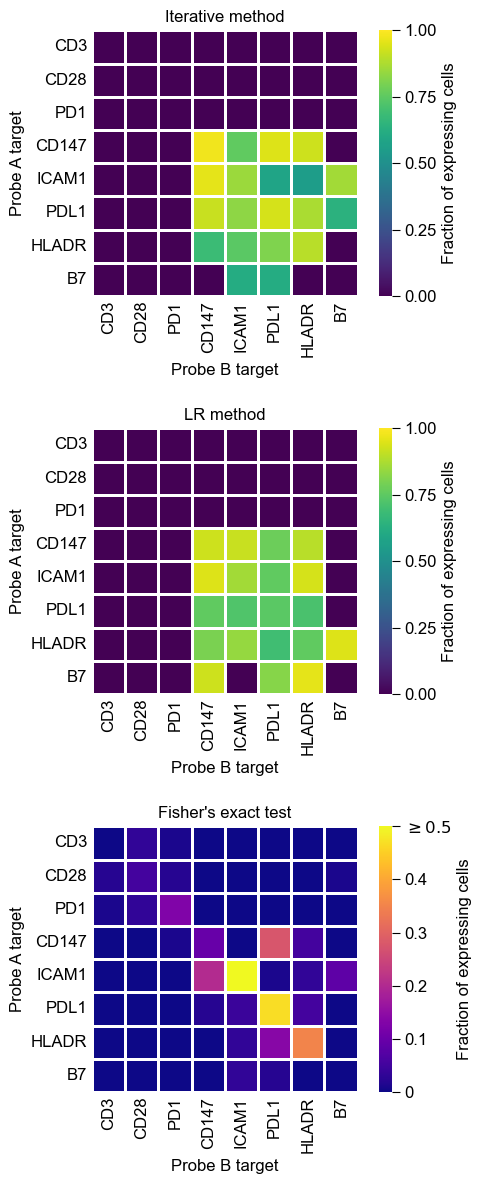

In [22]:
#Fig S7def
# Fisher's test: B cells   **Figure S7def**
fig, ax = plt.subplots(nrows=3, figsize=(5.2,12))
sns.heatmap(B_1_express.loc[my_order,my_order], ax=ax[0],
            linewidths=1, square=True,
            cmap='viridis',
            vmax=1, cbar_kws={'label':"Fraction of expressing cells",
                              'ticks':np.arange(0,1.1,0.25)})
ax[0].set_title("Iterative method")
sns.heatmap(B_2_express.loc[my_order,my_order], ax=ax[1],
            linewidths=1, square=True,
            cmap='viridis',
            vmax=1, cbar_kws={'label':"Fraction of expressing cells",
                              'ticks':np.arange(0,1.1,0.25)})
ax[1].set_title("LR method")
sns.heatmap(B_fisher_express.loc[my_order,my_order], ax=ax[2],
            linewidths=1, square=True,
            cmap='plasma',
            vmax=0.5, cbar_kws={'label':"Fraction of expressing cells",
                                'ticks':np.arange(0,0.55,0.1)})
ax[2].collections[0].colorbar.set_ticklabels(my_ticklabels)
ax[2].set_title("Fisher's exact test")
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(h_pad=1.8)
fig.savefig(myDir+"Bcells_heatmap_expressing_fraction_Fig S7def.svg",
            bbox_inches='tight', pad_inches=0)

In [228]:
#%% Simulate Jurkat and Raji      **Figure S8**
jurkat_complex = np.array([ [240,50,0,0,0,0,0,0,0],
                            [50,300,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0],
                            [0,0,0,0,0,0,0,0,0] ])
jurkat_atarget = np.array([50,330,3400,2400,16,3,100,1,10])
jurkat_btarget = np.array([50,330,3400,2400,16,3,100,1,10])
sim_jurkat = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist, seed_num=2022,
                            protein_variance=True, ligate_all=False)
sim_jurkat.simulate(jurkat_complex, jurkat_atarget, jurkat_btarget)

raji_complex = np.array([ [0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,3000,0,0,0],
                          [0,0,0,0,0,0,500,0,0],
                          [0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0] ])
raji_atarget = np.array([5,60,30,1000,2500,3,5000,4,1000])
raji_btarget = np.array([5,60,30,1000,2500,3,5000,4,1000])

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2022.
2023-01-27 14:40:06     Start simulation
2023-01-27 14:40:11     Processed     10 cells
2023-01-27 14:40:17     Processed     20 cells
2023-01-27 14:40:22     Processed     30 cells
2023-01-27 14:40:27     Processed     40 cells
2023-01-27 14:40:32     Processed     50 cells
2023-01-27 14:40:34     Processed     60 cells
2023-01-27 14:40:38     Processed     70 cells
2023-01-27 14:40:41     Processed     80 cells
2023-01-27 14:40:51     Processed     90 cells
2023-01-27 14:40:54     Processed    100 cells


In [229]:
pla_sim_jurkat = PC.plaObject(sim_jurkat.pla_count)
pla_sim_jurkat.predictComplex(method='iterative')
pla_sim_jurkat.predictComplex(method='lr', suffix='2',
                              non_proximal_count=sim_jurkat.non_proximal_count)

predictComplex done: Loop number 101, tolerance 0.96


In [230]:
sim_avg_T = pd.DataFrame({'mean':(pla_sim_jurkat.complex_count).mean(axis=1)})
sim_avg_T['probeA'] = [s.split(':')[0] for s in sim_avg_T.index]
sim_avg_T['probeB'] = [s.split(':')[1] for s in sim_avg_T.index]
sim_avg_T = sim_avg_T.pivot(index='probeA', columns='probeB', values='mean')
sim_avg_T.rename(columns={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},
                 index={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},inplace = True)

sim_avg_T2 = pd.DataFrame({'mean':(pla_sim_jurkat.complex_count2).mean(axis=1)})
sim_avg_T2['probeA'] = [s.split(':')[0] for s in sim_avg_T2.index]
sim_avg_T2['probeB'] = [s.split(':')[1] for s in sim_avg_T2.index]
sim_avg_T2 = sim_avg_T2.pivot(index='probeA', columns='probeB', values='mean')
sim_avg_T2.rename(columns={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},
                 index={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},inplace = True)

truecount = pd.DataFrame(jurkat_complex,index = my_order, columns = my_order)

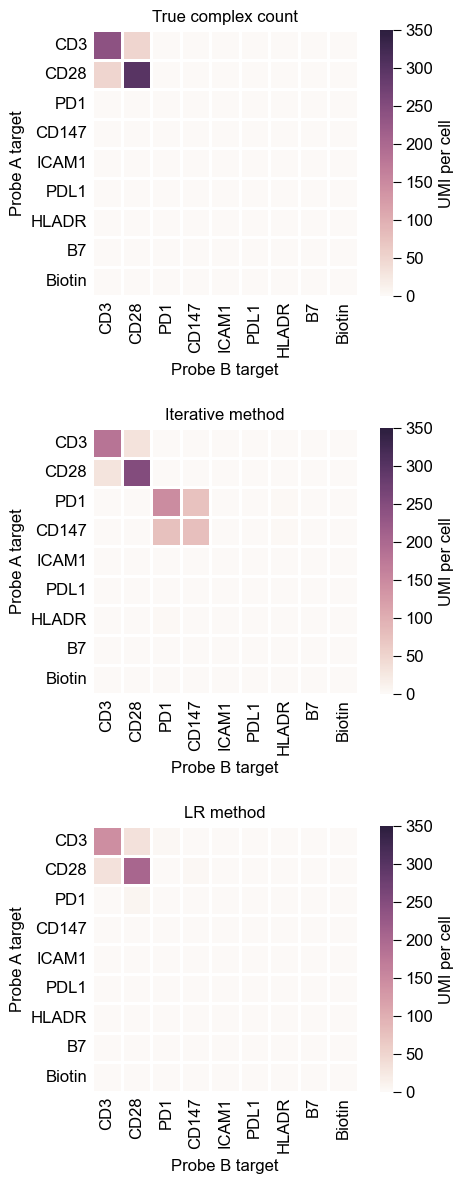

In [231]:
fig, ax = plt.subplots(nrows=3, figsize=(5.2,12))
sns.heatmap(truecount, ax=ax[0],
            linewidths=1, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            vmax=350, cbar_kws={'label':"UMI per cell",})
ax[0].set_title("True complex count")
sns.heatmap(sim_avg_T, ax=ax[1],
            linewidths=1, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            vmax=350, cbar_kws={'label':"UMI per cell",})
ax[1].set_title("Iterative method")
sns.heatmap(sim_avg_T2, ax=ax[2],
            linewidths=1, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            vmax=350, cbar_kws={'label':"UMI per cell",})
ax[2].set_title("LR method")
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(h_pad=1.8)
fig.savefig(myDir+"Simulation of T cells'experimental data_Fig S8abc.svg",
            bbox_inches='tight', pad_inches=0)

In [232]:
sim_raji = PC.simulatePLA(n_cells=100, cell_d=d, PLA_dist=PLA_dist, seed_num=2022,
                            protein_variance=True, ligate_all=False)
sim_raji.simulate(raji_complex, raji_atarget, raji_btarget)

cell_d=10000. PLA_dist=50.
protein_variance=True. Negative binomial: n=1.5. seed_num=2022.
2023-01-27 14:41:17     Start simulation
2023-01-27 14:41:47     Processed     10 cells
2023-01-27 14:41:57     Processed     20 cells
2023-01-27 14:42:08     Processed     30 cells
2023-01-27 14:42:24     Processed     40 cells
2023-01-27 14:42:30     Processed     50 cells
2023-01-27 14:42:50     Processed     60 cells
2023-01-27 14:43:01     Processed     70 cells
2023-01-27 14:43:10     Processed     80 cells
2023-01-27 14:43:18     Processed     90 cells
2023-01-27 14:43:44     Processed    100 cells


In [233]:
pla_sim_raji = PC.plaObject(sim_raji.pla_count)
pla_sim_raji.predictComplex(method='iterative')
pla_sim_raji.predictComplex(method='lr', suffix='2',
                              non_proximal_count=sim_raji.non_proximal_count)

predictComplex done: Loop number 200, tolerance 14.07


In [234]:
sim_avg_B = pd.DataFrame({'mean':(pla_sim_raji.complex_count).mean(axis=1)})
sim_avg_B['probeA'] = [s.split(':')[0] for s in sim_avg_B.index]
sim_avg_B['probeB'] = [s.split(':')[1] for s in sim_avg_B.index]
sim_avg_B = sim_avg_B.pivot(index='probeA', columns='probeB', values='mean')
sim_avg_B.rename(columns={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},
                 index={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},inplace = True)

sim_avg_B2 = pd.DataFrame({'mean':(pla_sim_raji.complex_count2).mean(axis=1)})
sim_avg_B2['probeA'] = [s.split(':')[0] for s in sim_avg_B2.index]
sim_avg_B2['probeB'] = [s.split(':')[1] for s in sim_avg_B2.index]
sim_avg_B2 = sim_avg_B2.pivot(index='probeA', columns='probeB', values='mean')
sim_avg_B2.rename(columns={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},
                 index={"1": "CD3", "2": "CD28","3":"PD1","4":"CD147","5":"ICAM1","6":"PDL1","7":"HLADR","8":"B7","9":"Biotin"},inplace = True)

truecount = pd.DataFrame(raji_complex,index = my_order, columns = my_order)

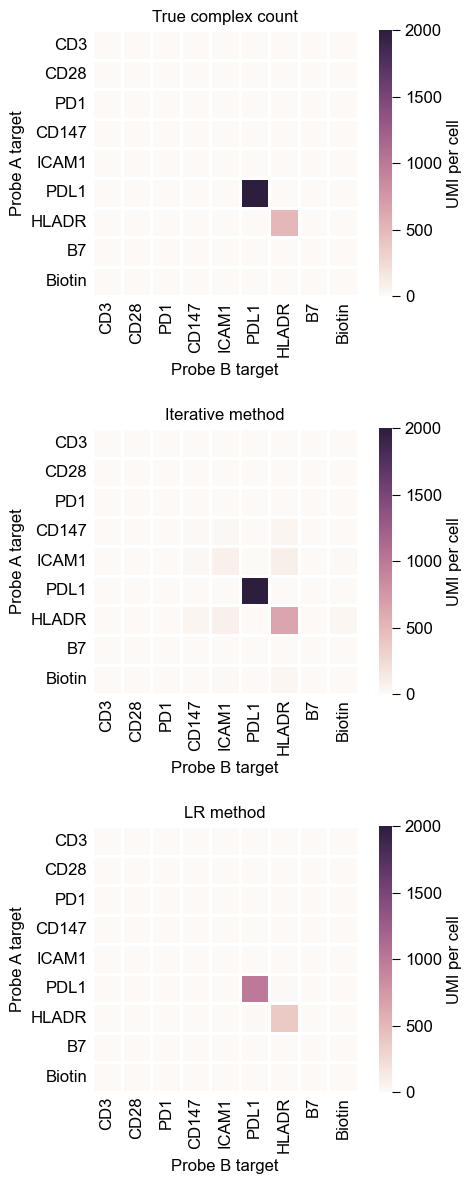

In [235]:
fig, ax = plt.subplots(nrows=3, figsize=(5.2,12))
sns.heatmap(truecount, ax=ax[0],
            linewidths=1, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            vmax=2000, cbar_kws={'label':"UMI per cell",})
ax[0].set_title("True complex count")
sns.heatmap(sim_avg_B, ax=ax[1],
            linewidths=1, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            vmax=2000, cbar_kws={'label':"UMI per cell",})
ax[1].set_title("Iterative method")
sns.heatmap(sim_avg_B2, ax=ax[2],
            linewidths=1, square=True,
            cmap=sns.cubehelix_palette(light=.98, dark=0.15, as_cmap=True),
            vmax=2000, cbar_kws={'label':"UMI per cell",})
ax[2].set_title("LR method")
for i in ax:
    i.set_xlabel("Probe B target")
    i.set_ylabel("Probe A target")
    i.tick_params(axis='both', length=0)
fig.tight_layout(h_pad=1.8)
fig.savefig(myDir+"Simulation of B cells'experimental data_Fig S8def.svg",
            bbox_inches='tight', pad_inches=0)